In [1]:
import os
from time import time
from tqdm import tqdm
import numpy as np
import torch
from torch import optim
from torch.nn import Linear, CrossEntropyLoss
from torch.optim import Adam
from torch.utils.data import DataLoader
import torchvision
from torchvision.datasets import ImageFolder
from torchvision.models import resnet50
from torchvision.transforms import transforms
import torch.nn as nn

In [2]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import seaborn as sns

In [3]:
import matplotlib.pyplot as plt


In [4]:
tfm = transforms.Compose([
    transforms.Resize((224, 224)),# resize is necessary as resnet50 accepts only 224,224 size images
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(degrees=10),
    transforms.ToTensor(),  # Convert the PIL Image to a PyTorch tensor
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]) # Normalizing the image with basic resnet50 mean and standard deviation
])

In [9]:
TRAIN_PATH = ("/content/drive/MyDrive/EAI6010/Brain Tumor Classification (MRI)/Training")
trainset = ImageFolder(TRAIN_PATH,transform= tfm)

In [10]:
TRAIN_PATH = ("/content/drive/MyDrive/EAI6010/Brain Tumor Classification (MRI)/Testing")
testset  = ImageFolder(TRAIN_PATH,transform= tfm)

In [11]:
LEN_TRAIN=len(trainset)
LEN_TEST = len(testset)
print(LEN_TRAIN, LEN_TEST)

1222 179


100%|██████████| 25/25 [20:46<00:00, 49.86s/batch]


Epoch: 0, loss: 0.14069223403930664
Train Acc: 0.9304418985270049, Test Acc: 0.6312849162011173


100%|██████████| 25/25 [17:28<00:00, 41.92s/batch]


Epoch: 1, loss: 0.09102747589349747
Train Acc: 0.9893617021276596, Test Acc: 0.9162011173184358


100%|██████████| 25/25 [17:19<00:00, 41.59s/batch]


Epoch: 2, loss: 0.01801127940416336
Train Acc: 0.9934533551554828, Test Acc: 0.9497206703910615


100%|██████████| 25/25 [17:10<00:00, 41.21s/batch]


Epoch: 3, loss: 0.0006111323600634933
Train Acc: 0.9959083469721768, Test Acc: 0.9106145251396648


100%|██████████| 25/25 [17:13<00:00, 41.33s/batch]


Epoch: 4, loss: 0.03711480274796486
Train Acc: 0.9909983633387889, Test Acc: 0.7877094972067039


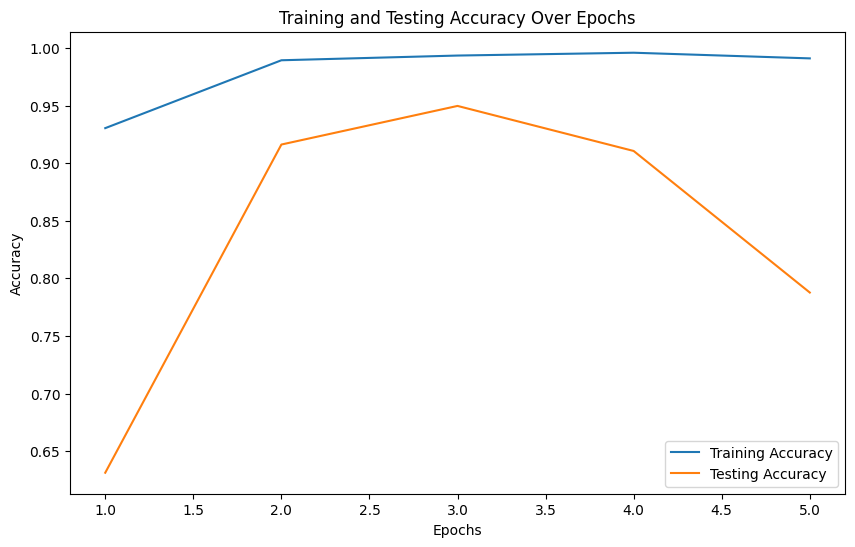

In [12]:

train_loader = DataLoader(trainset, batch_size=50, shuffle=True) # dividing the dataset into batches for training
test_loader = DataLoader(testset, batch_size=50, shuffle=True)

model = resnet50(pretrained=True) # calling pretrained resnet model
model.fc = Linear(in_features=2048, out_features=4, bias=True) # just configuring the output layer according to our requirement

optimizer = optim.Adam(model.parameters(), lr=3e-4, weight_decay=0.0001) # here decaying is use to avoid overfitting
loss_fn = nn.CrossEntropyLoss() # loss function

train_accuracy_values = []
test_accuracy_values = []


for epoch in range(5): # training the model for 5 epoches and calculating test and train loss and accuracy per epoch
    tr_acc = 0
    test_acc = 0
    model.train()

    with tqdm(train_loader, unit="batch") as tepoch:
        for xtrain, ytrain in tepoch:
            optimizer.zero_grad()

            train_prob = model(xtrain)
            loss = loss_fn(train_prob, ytrain)
            loss.backward() # use for backpropogating loss
            optimizer.step()

            train_pred = torch.max(train_prob, 1).indices
            tr_acc += int(torch.sum(train_pred == ytrain))
        ep_tr_acc = tr_acc / LEN_TRAIN
        train_accuracy_values.append(ep_tr_acc)

    model.eval()
    with torch.no_grad():
        for xtest, ytest in test_loader:
            test_prob = model(xtest)
            test_pred = torch.max(test_prob, 1).indices
            test_acc += int(torch.sum(test_pred == ytest))

        ep_test_acc = test_acc / LEN_TEST
        test_accuracy_values.append(ep_test_acc)

    print(f"Epoch: {epoch}, loss: {loss}\nTrain Acc: {ep_tr_acc}, Test Acc: {ep_test_acc}")




# plotting testing and training accuracy to check overfitting
plt.figure(figsize=(10, 6))
plt.plot(range(1, 6), train_accuracy_values, label='Training Accuracy')
plt.plot(range(1, 6), test_accuracy_values, label='Testing Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training and Testing Accuracy Over Epochs')
plt.legend()
plt.show()







<Figure size 800x600 with 0 Axes>

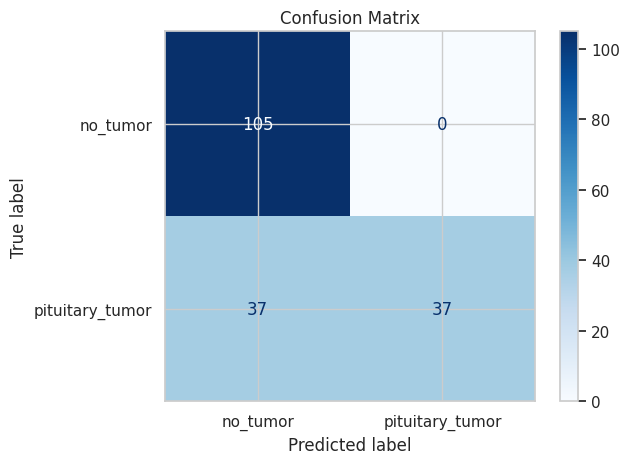

In [24]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

import seaborn as sns
labels = []
preds = []

with torch.no_grad():
    for xtest, ytest in test_loader:
        testprob = model(xtest)
        testpred = torch.max(testprob, 1).indices
        labels.extend(ytest.cpu().numpy())
        preds.extend(testpred.cpu().numpy())

# Convert to numpy arrays
labels = np.array(labels)
preds = np.array(preds)


# Create confusion matrix
cm = confusion_matrix(labels, preds)
# Customizing the Seaborn style and color palette
#sns.set(style='whitegrid')
#sns.set_palette("pastel")

# Plot confusion matrix
class_names = ['no_tumor', 'pituitary_tumor']
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
plt.figure(figsize=(8, 6))
disp.plot(cmap='Blues', values_format='d')
plt.title('Confusion Matrix')
plt.show()


In [17]:
# mapping
print(trainset.class_to_idx)

{'no_tumor': 0, 'pituitary_tumor': 1}


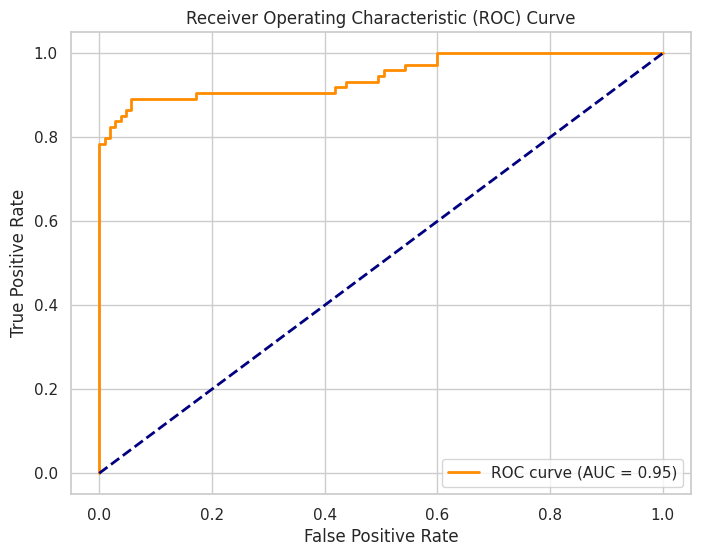

In [19]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

# Assuming you have your model and test_loader already defined

model.eval()

labels = []
probs = []

with torch.no_grad():
    for xtest, ytest in test_loader:
        testprob = model(xtest)

        labels.extend(ytest.cpu().numpy())
        probs.extend(testprob[:, 1].cpu().numpy())  # Assuming you are doing binary classification, take the probability of the positive class

# Convert to numpy arrays
labels = np.array(labels)
probs = np.array(probs)

# Compute ROC curve and AUC
fpr, tpr, thresholds = roc_curve(labels, probs)
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (AUC = {:.2f})'.format(roc_auc))
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()


In [20]:
testing1 = ("/content/drive/MyDrive/EAI6010/Brain Tumor Classification (MRI)/Testing/no_tumor/image(19).jpg") # not a cancer image
testing2 = ("/content/drive/MyDrive/EAI6010/Brain Tumor Classification (MRI)/Testing/no_tumor/image(37).jpg") #not a cancer image
testing3 = ("/content/drive/MyDrive/EAI6010/Brain Tumor Classification (MRI)/Testing/pituitary_tumor/image(37).jpg") # cancer image
testing4 = ("/content/drive/MyDrive/EAI6010/Brain Tumor Classification (MRI)/Testing/pituitary_tumor/image(7).jpg") # cancer image
testing_split = [testing2 , testing2, testing3, testing4]

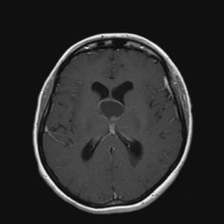

model prediction 0, not cancer


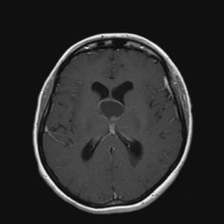

model prediction 0, not cancer


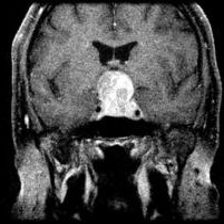

model prediction 0, not cancer


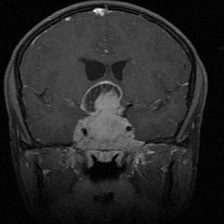

model prediction 0, not cancer


In [22]:
from PIL import Image
import numpy as np
for image_path in testing_split:
  img = Image.open(image_path)
  display(img.resize(((224,224))))
  img_tensor = tfm(img)
  img_tensor = img_tensor[np.newaxis,:]
  pred_prob = model(img_tensor)
  pred= torch.max(pred_prob,1).indices
  pred=pred.item()
  if pred == 1:
    print(f"model prediction {pred}, cancer")
  else:
    print(f"model prediction {pred}, not cancer")
  print("=======================================================")